In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy.stats import chisquare
from math import log10


In [2]:
# do not run this if it is not necessary, this is to get data from philly website
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import requests
from bs4 import BeautifulSoup as bs
import itertools
import time

def get_data():
    driver = webdriver.Chrome()
    driver.implicitly_wait(30)
    driver.maximize_window()
    driver.get("https://results.philadelphiavotes.com/ResultsSW.aspx?type=FED&map=CTY")
    button = driver.find_elements_by_xpath('/html/body/form/div[4]/div[8]/input[2]')
    button[0].click()

    time.sleep(10)
    
    res_all = []
    keep_adding = True

    while keep_adding:
        results = driver.find_elements_by_id('Datawrapper2')
        results = results[0]
        soup = bs(results.get_attribute('innerHTML'), 'html.parser')
        all_titles = [x.text.strip() for x in soup.findAll("div", {"class": "precinct-results-orangebox-title"})]
        all_titles = list(itertools.chain.from_iterable(itertools.repeat(x, 4) for x in all_titles))
        all_challengers = [x.findAll('h1')[0].text.strip() for x in soup.findAll("div", {"class": "col-precinct-results precinct-results-databox1"})]
        all_results = [x.findAll('h1')[0].text.strip() for x in soup.findAll("div", {"class": "col-precinct-results precinct-results-databox7"})]
        res = pd.DataFrame({
            'district': all_titles,
            'candidate': all_challengers,
            'votes': all_results
        })
        res_all.append(res)

        pager2 = driver.find_element_by_id('Pager2')
        all_next_buttons = pager2.find_elements_by_tag_name('a')
        final_button_text = all_next_buttons[-1].text
        if final_button_text == 'Next':
            next_button = all_next_buttons[-1]
            time.sleep(1)
            next_button.click()
        else:
            keep_adding = False
    df_results = pd.concat(res_all)
    return df_results

# do not run this if it is not necessary, this is to get data from philly website
# df_results = get_data()
# df_results.to_csv('data_philly.csv')

In [3]:
df_results = pd.read_csv('data_philly.csv')

In [4]:
df_results = df_results.pivot('district', 'candidate', 'votes')
for col in df_results.columns:
    df_results[col] = df_results[col].str.replace(',', '').astype(int)
df_results['total'] = df_results.sum(axis=1)
cols = ['DONALD J TRUMP AND MICHAEL R PENCE', 'JOSEPH R BIDEN AND KAMALA D HARRIS']
df_results = df_results[cols]
df_results.columns = ['republican', 'democrat']
df_results = df_results.loc[(df_results >= 1).all(axis=1)]

In [5]:
first_digits = df_results.copy()
for col in first_digits.columns:
    first_digits[col] = first_digits.query(f'{col} >= 1')[col].astype(str).str[:1]
first_digits = first_digits.astype(int)

In [6]:
df_compare = pd.DataFrame({'republican': first_digits['republican'].value_counts(),
                           'democrat': first_digits['democrat'].value_counts()})
df_compare = df_compare.loc[df_compare.index > 0]
df_compare['benford_democrat'] = np.log10(1 + 1 / pd.Series(data=range(1,100), index=range(1,100))) * df_compare['democrat'].sum()
df_compare['benford_republican'] = np.log10(1 + 1 / pd.Series(data=range(1,100), index=range(1,100))) * df_compare['republican'].sum()
df_compare = df_compare.fillna(0)

In [7]:
df_compare

,republican,democrat,benford_democrat,benford_republican
1,538,287,511.750993,511.750993
2,281,499,299.355140,299.355140
3,180,456,212.395852,212.395852
4,130,277,164.747022,164.747022
5,115,111,134.608118,134.608118
6,122,39,113.809542,113.809542
7,108,18,98.586310,98.586310
8,127,6,86.959288,86.959288
9,99,7,77.787734,77.787734


In [8]:
chi_democrat, pval_democrat = chisquare(df_compare['democrat'], df_compare['benford_democrat'])
chi_republican, pval_republican = chisquare(df_compare['republican'], df_compare['benford_republican'])

In [9]:
chi_democrat, pval_democrat

(846.7141777024283, 1.7514704623707273e-177)

In [10]:
chi_republican, pval_republican

(43.30753019813052, 7.687141792970334e-07)

In [11]:
# draw graph
df_graph = df_compare.copy()
df_graph = df_graph / df_graph.sum()
df_graph = df_graph.rename({'benford_republican': 'benford'}, axis=1).drop(columns='benford_democrat', axis=1)

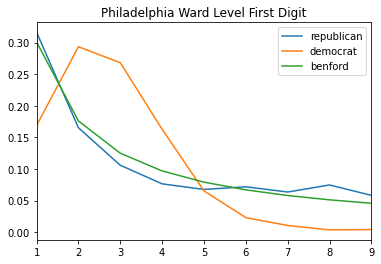

In [13]:
df_graph.plot(title='Philadelphia Ward Level First Digit')